In [103]:
!pip install torch torchvision scikit-learn pandas matplotlib kaggle

3209.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# Chuẩn hóa cột 'Amount' và 'Time'
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data['Time_scaled'] = scaler.fit_transform(data[['Time']])

# Xóa các cột 'Class', 'Amount', và 'Time' chưa chuẩn hóa
X = data.drop(columns=['Class', 'Amount', 'Time'])

# Thêm cột 'Amount_scaled' và 'Time_scaled'
X['Amount'] = data['Amount_scaled']
X['Time'] = data['Time_scaled']

# Nhãn dữ liệu
y = data['Class']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuyển đổi sang tensor cho PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


In [105]:
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2_mu = nn.Linear(32, latent_dim)
        self.fc2_logvar = nn.Linear(32, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Khởi tạo mô hình VAE
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [106]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Huấn luyện mô hình
epochs = 50
model.train()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=32, shuffle=True)

for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')


Epoch 1, Loss: 33.72507619322237
Epoch 2, Loss: 33.02787097365932
Epoch 3, Loss: 32.89282565397424
Epoch 4, Loss: 32.82843160853832
Epoch 5, Loss: 32.79117199709978
Epoch 6, Loss: 32.77296111671451
Epoch 7, Loss: 32.74829639007127
Epoch 8, Loss: 32.7311190477188
Epoch 9, Loss: 32.7131904759263
Epoch 10, Loss: 32.705416137197055
Epoch 11, Loss: 32.697864449109744
Epoch 12, Loss: 32.6976282807324
Epoch 13, Loss: 32.69172699705253
Epoch 14, Loss: 32.682929940338695
Epoch 15, Loss: 32.68129900288332
Epoch 16, Loss: 32.681169782213
Epoch 17, Loss: 32.67612484050013
Epoch 18, Loss: 32.675886756746124
Epoch 19, Loss: 32.733417705718466
Epoch 20, Loss: 32.66971437227823
Epoch 21, Loss: 32.65731463895347
Epoch 22, Loss: 32.65547202272546
Epoch 23, Loss: 32.65574039036564
Epoch 24, Loss: 32.65506134743086
Epoch 25, Loss: 32.64202357789868
Epoch 26, Loss: 32.64387063933014
Epoch 27, Loss: 32.641671113432764
Epoch 28, Loss: 32.63294357215757
Epoch 29, Loss: 32.63406521688082
Epoch 30, Loss: 32.630

In [107]:
# Đặt mô hình vào chế độ đánh giá
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)  # Ngưỡng 95% của lỗi tái tạo

# Gán nhãn dự đoán dựa trên ngưỡng
y_pred = (reconstruction_loss > threshold).astype(int)  # 1 là bất thường, 0 là bình thường

# So sánh kết quả với nhãn thực tế
import pandas as pd

# Tạo DataFrame chứa kết quả dự đoán và nhãn thực tế
results_df = pd.DataFrame({
    'Reconstruction_Loss': reconstruction_loss,   # Lỗi tái tạo từ VAE
    'Predicted_Anomaly': y_pred,                  # 1 là bất thường, 0 là bình thường
    'Actual_Label': y_test.values                 # Nhãn thực tế từ dữ liệu
})

# Hiển thị các giao dịch mà mô hình đánh dấu là gian lận và so sánh với nhãn thực tế
fraud_cases = results_df[results_df['Predicted_Anomaly'] == 1]  # Các giao dịch được dự đoán là gian lận
print(fraud_cases.head())  # Hiển thị một số giao dịch bị dự đoán là gian lận

# Hiển thị các giao dịch mà mô hình bỏ sót (thực tế là gian lận nhưng không được dự đoán)
missed_fraud_cases = results_df[(results_df['Predicted_Anomaly'] == 0) & (results_df['Actual_Label'] == 1)]
print("Missed fraud cases:")
print(missed_fraud_cases.head())


    Reconstruction_Loss  Predicted_Anomaly  Actual_Label
0             73.967270                  1             1
9              2.543533                  1             0
31             2.172292                  1             0
32           119.621941                  1             0
41             2.690303                  1             0
Missed fraud cases:
       Reconstruction_Loss  Predicted_Anomaly  Actual_Label
8379              0.812918                  0             1
10279             0.869578                  0             1
17388             0.763269                  0             1
22797             1.646960                  0             1
30129             1.897884                  0             1


In [108]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# So sánh kết quả với nhãn thực tế
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Confusion Matrix:
 [[54102  2762]
 [   11    87]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.89      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962

ROC AUC Score: 0.9195915352635144


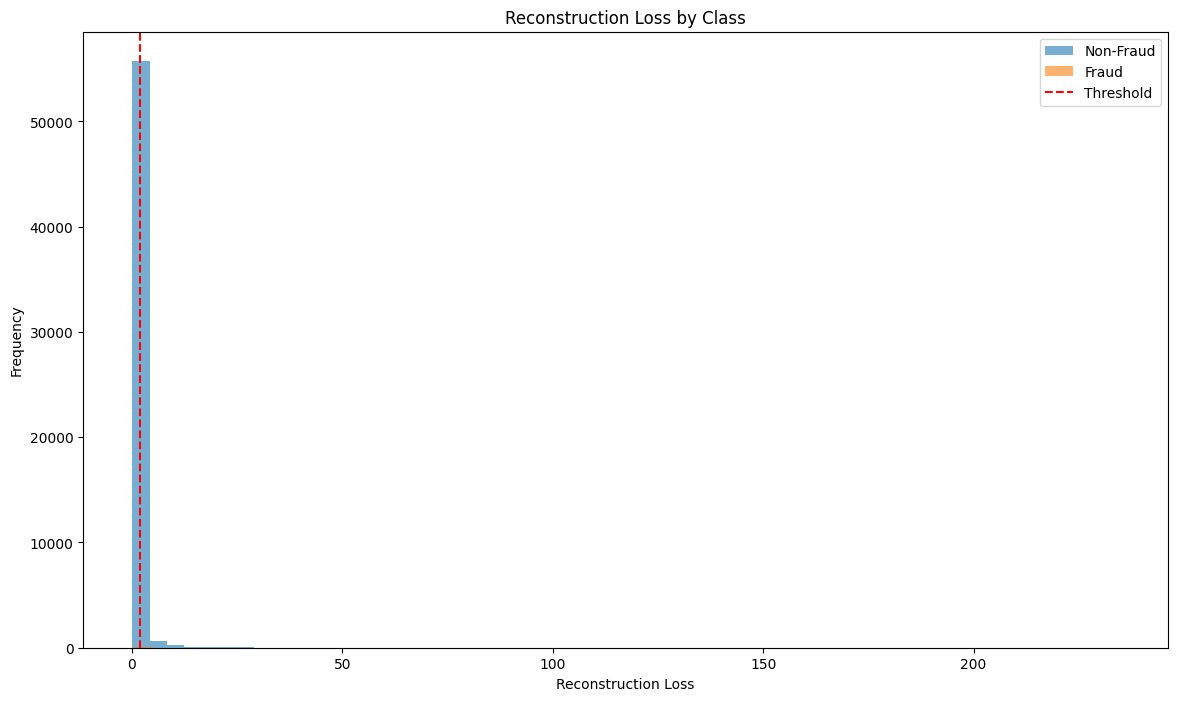

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ phân phối của reconstruction_loss
plt.figure(figsize=(14, 8))
plt.hist(reconstruction_loss[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud')
plt.hist(reconstruction_loss[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Loss by Class')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [110]:
# Hiển thị các giao dịch được dự đoán là gian lận
fraud_cases = results_df[results_df['Predicted_Anomaly'] == 1]
print("Predicted Fraud Cases:")
print(fraud_cases.head())

# Hiển thị các giao dịch mà mô hình dự đoán sai (False Positives và False Negatives)
false_positives = results_df[(results_df['Predicted_Anomaly'] == 1) & (results_df['Actual_Label'] == 0)]
false_negatives = results_df[(results_df['Predicted_Anomaly'] == 0) & (results_df['Actual_Label'] == 1)]

print("False Positives (Predicted Fraud, but Actually Non-Fraud):")
print(false_positives.head())

print("False Negatives (Predicted Non-Fraud, but Actually Fraud):")
print(false_negatives.head())


Predicted Fraud Cases:
    Reconstruction_Loss  Predicted_Anomaly  Actual_Label
0             73.967270                  1             1
9              2.543533                  1             0
31             2.172292                  1             0
32           119.621941                  1             0
41             2.690303                  1             0
False Positives (Predicted Fraud, but Actually Non-Fraud):
    Reconstruction_Loss  Predicted_Anomaly  Actual_Label
9              2.543533                  1             0
31             2.172292                  1             0
32           119.621941                  1             0
41             2.690303                  1             0
44             2.883421                  1             0
False Negatives (Predicted Non-Fraud, but Actually Fraud):
       Reconstruction_Loss  Predicted_Anomaly  Actual_Label
8379              0.812918                  0             1
10279             0.869578                  0          